In [34]:
import open3d as o3d
import numpy as np
import copy as cp
import open3d.core as o3c
import matplotlib.pyplot as plt
import pyransac3d as pyrsc
from scipy.spatial.transform import Rotation
from iteration_utilities import deepflatten
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#load pcd file, filter, downsample
pcdn = o3d.io.read_point_cloud("final_cropped.pcd")
pcdn.estimate_normals()
cl, ind = pcdn.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=0.8)

pcd = pcdn.select_by_index(ind)
pcd = pcd.voxel_down_sample(voxel_size=0.1)
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(40)
o3d.visualization.draw_geometries([pcd])

In [3]:
# detect boundarys in pointcloud

test2 = cp.deepcopy(pcd)

tensor_pcd = o3d.t.geometry.PointCloud.from_legacy(test2)

boundarys, mask = tensor_pcd.compute_boundary_points(0.2, 100, 95)
# TODO: not good to get size of points.
print(f"Detect {boundarys.point.positions.shape[0]} bnoundary points from {tensor_pcd.point.positions.shape[0]} points.")

boundarys = boundarys.paint_uniform_color([1.0, 0.0, 0.0])
cl, ind = boundarys.to_legacy().remove_radius_outlier(2, 0.2)
boundarys = boundarys.select_by_index(ind)


o3d.visualization.draw_geometries([tensor_pcd.to_legacy().paint_uniform_color([0, 0, 0.0]), boundarys.to_legacy()])

Detect 15121 bnoundary points from 106083 points.


In [4]:
# detect patches in boundary points

test4 = cp.deepcopy(boundarys.to_legacy())


test4.estimate_normals()
test4.orient_normals_consistent_tangent_plane(30)


n_points = len(test4.points)
#o3d.visualization.draw([pcd_down])
# using all defaults
oboxes = test4.detect_planar_patches(
normal_variance_threshold_deg=60,
coplanarity_deg=80,
outlier_ratio=0.75,
min_plane_edge_length=0.2,
min_num_points=5,
search_param=o3d.geometry.KDTreeSearchParamKNN(knn=50))

print("Detected {} patches".format(len(oboxes)))

geometries = []
for obox in oboxes:

    mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
    mesh.paint_uniform_color(obox.color)
    mesh.compute_triangle_normals()
    mesh.compute_vertex_normals()
    normals = np.asarray(mesh.vertex_normals)

    
    geometries.append(mesh)
    #geometries.append(obox)

o3d.visualization.draw_geometries(geometries )
#o3d.visualization.draw_geometries([pcd])

Detected 126 patches


In [5]:
def add_vector_to_point(point, vector, length):
    

    # Calculate the new point coordinates
    new_point = point + length * vector

    # Return the new point as a NumPy array
    return new_point

In [6]:
def calc_mesh_area_sorted(meshes):
    areas = np.zeros((len(meshes),2))
    for i in range(len(meshes)):
        mesh_bb = meshes[i].get_oriented_bounding_box()
        area = mesh_bb.volume()/mesh_bb.extent[2]
        areas[i][0] = i
        areas[i][1] = area
    sorted_indices = np.argsort(areas[:, 1])[::-1]
    return areas[sorted_indices]
        

In [7]:
dimensions = calc_mesh_area_sorted(geometries)


In [8]:
middle = geometries[115].get_center()
normal = np.asarray(geometries[115].vertex_normals)[0]

cam_pos = add_vector_to_point(middle, normal, 5)
print(middle)
print(cam_pos)
cam_pos[2] = 0.5
middle[2] = 0.5
print(middle)
print(cam_pos)

[-37.55931125   0.48600167  -1.63776755]
[-37.73427908   0.58178916   3.35825197]
[-37.55931125   0.48600167   0.5       ]
[-37.73427908   0.58178916   0.5       ]


In [9]:
scene = o3d.t.geometry.RaycastingScene()

for mesh in geometries:
    
    scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))



In [10]:
def count_hits_ray_cast(hit_array, dist_thresh):
    dist_lower = dist_thresh[0]
    dist_upper = dist_thresh[1]
    flattened_hit_array = hit_array.flatten()
    n_pixels = len(flattened_hit_array)
    
    
    n_hits = np.sum((flattened_hit_array >= dist_lower) & (flattened_hit_array <= dist_upper))
    
    return n_hits/n_pixels
    

In [12]:
def compute_transform(vector1, vector2):
    # Normalize the vectors to unit length
    vector1 = vector1 / np.linalg.norm(vector1)
    vector2 = vector2 / np.linalg.norm(vector2)

    # Compute the rotation matrix
    rotation_matrix = Rotation.align_vectors([vector1], [vector2])[0].as_matrix()

    # Compute the translation vector
    translation_vector = vector2 - np.dot(rotation_matrix, vector1)

    return translation_vector, rotation_matrix

In [17]:
def rotation_matrix_to_axis_angle(matrix):
    r = Rotation.from_matrix(matrix)
    return r.as_euler('xyz', degrees=True)

In [37]:
def visualize_3d_vectors(vector1, vector2):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract individual coordinates from the vectors
    x1, y1, z1 = vector1
    x2, y2, z2 = vector2
    
    # Plot the vectors as lines
    ax.plot([0, x1], [0, y1], [0, z1], color='r', label='Vector 1')
    ax.plot([0, x2], [0, y2], [0, z2], color='b', label='Vector 2')
    
    # Set the limits and labels of the plot
    max_x = max(np.max(x1), np.max(x2))
    max_y = max(np.max(y1), np.max(y2))
    max_z = max(np.max(z1), np.max(z2))
    ax.set_xlim([0, max_x])
    ax.set_ylim([0, max_y])
    ax.set_zlim([0, max_z])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add a legend
    ax.legend()
    
    # Show the plot
    plt.show()

Normal of plane:  [ 0.01653912  0.99920696 -0.03622037]
Camera direction:  [ 0.17496783 -0.09578749  0.        ]
Camera direction:  [-0.17496783  0.09578749  0.        ]
[-92.28203817  26.60358918 -92.04463141]


/tmp/ipykernel_4888/927153186.py:7: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation_matrix = Rotation.align_vectors([vector1], [vector2])[0].as_matrix()
/tmp/ipykernel_4888/836121750.py:20: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_zlim([0, max_z])


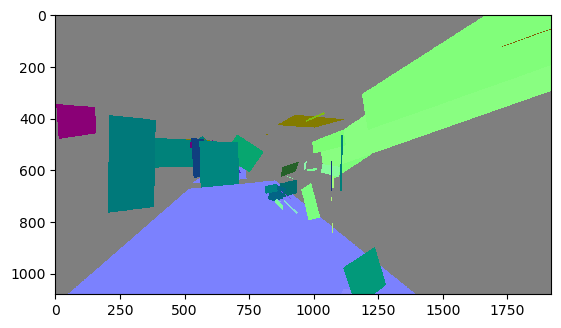

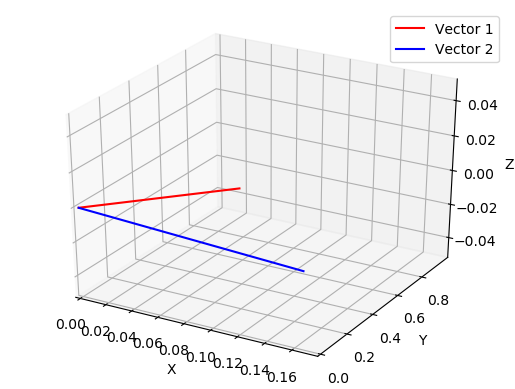

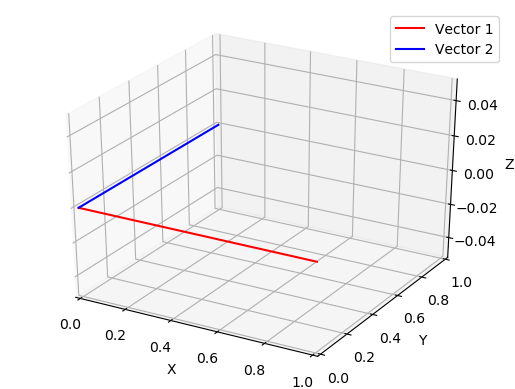

In [41]:
rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=120,
    center=middle,
    eye=cam_pos,
    up=[0, 0, -1],
    width_px=1920,
    height_px=1080,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)
plt.imshow(ans['t_hit'].numpy())

normals = ans['primitive_normals'].numpy()

normals_interp = np.interp(normals, (normals.min(), normals.max()), (0, 1))
plt.imshow(normals_interp)
hits = ans['t_hit'].numpy()

print("Normal of plane: " ,normals[0,1919])
print("Camera direction: ", (middle-cam_pos))
print("Camera direction: ", (cam_pos-middle))
_, rot_mat = compute_transform(normals[0,1919],(cam_pos-middle))
print(rotation_matrix_to_axis_angle(rot_mat))
visualize_3d_vectors(normals[0,1919],(middle-cam_pos) )
visualize_3d_vectors(np.asarray([1,0,0]),np.asarray([0,1,0]) )